In [5]:
# 7.1转化数据类型
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

# 定义函数转化变量类型。
# 生成整数型属性
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# 生成字符串型属性
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# 读取mnist数据。
# mnist = input_data.read_data_sets("../../datasets/MNIST_data",dtype=tf.uint8, one_hot=True)
mnist = input_data.read_data_sets("../../datasets/MNIST_data", one_hot=True)
images = mnist.train.images
labels = mnist.train.labels
pixels = images.shape[1]
num_examples = mnist.train.num_examples

# 输出TFRecord文件的地址。
filename = "Records/output.tfrecords"
writer = tf.python_io.TFRecordWriter(filename)
for index in range(num_examples):
    image_raw = images[index].tostring()

    example = tf.train.Example(features=tf.train.Features(feature={
        'pixels': _int64_feature(pixels),
        'label': _int64_feature(np.argmax(labels[index])),
        'image_raw': _bytes_feature(image_raw)
    }))
    writer.write(example.SerializeToString())
writer.close()
print("TFRecord文件已保存。")

C:\Users\adward\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting ../../datasets/MNIST_data\train-images-idx3-ubyte.gz


Extracting ../../datasets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ../../datasets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../../datasets/MNIST_data\t10k-labels-idx1-ubyte.gz


TFRecord文件已保存。


In [6]:
# 读取文件。
# 创建reader读取样例
reader = tf.TFRecordReader()
# 创建队列来维护文件列表
filename_queue = tf.train.string_input_producer(["Records/output.tfrecords"])
_,serialized_example = reader.read(filename_queue)

# 解析读取的样例。
features = tf.parse_single_example(
    serialized_example,
    features={
        'image_raw':tf.FixedLenFeature([],tf.string),
        'pixels':tf.FixedLenFeature([],tf.int64),
        'label':tf.FixedLenFeature([],tf.int64)
    })

# decode_raw将字符串转换成图像对应的像素数组
images = tf.decode_raw(features['image_raw'],tf.uint8)
labels = tf.cast(features['label'],tf.int32)
pixels = tf.cast(features['pixels'],tf.int32)

sess = tf.Session()

# 启动多线程处理输入数据。
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess,coord=coord)

# 每次读取完一个数据继续读取
for i in range(10):
    image, label, pixel = sess.run([images, labels, pixels])

In [8]:
# 7.2 图像处理
import tensorflow as tf
import matplotlib.pyplot as plt
image_raw_data = tf.gfile.FastGFile("../../datasets/cat.jpeg",'rb').read()
with tf.Session() as sess:
    # 使用tf.iamge.decode_jepg解码
    img_data = tf.image.decode_jpeg(image_raw_data)
    print(img_data.eval())
    
    plt.imshow(img_data.eval())
    plt.show()
    
    # 将一个图像的三位矩阵按照jepg格式存入文件，并打开
    # 看得到一个与原始图像一样的图片
    encode_image = tf.image.encode_jpeg(img_data)
    with tf.gfile.GFile("../../datasets/cat.jpeg","wb") as f:
        f.write(encode_image.eval())

[[[ 59  58  63]
  [ 61  60  65]
  [ 63  62  67]
  ...
  [125 163 200]
  [125 163 200]
  [125 163 200]]

 [[ 60  59  64]
  [ 61  60  65]
  [ 63  62  67]
  ...
  [126 164 201]
  [126 164 201]
  [126 164 201]]

 [[ 61  60  65]
  [ 63  62  67]
  [ 64  65  69]
  ...
  [126 164 201]
  [126 164 201]
  [126 164 201]]

 ...

 [[ 32  41  40]
  [ 33  42  41]
  [ 34  43  42]
  ...
  [  9  17   4]
  [  9  17   4]
  [  9  17   4]]

 [[ 32  41  40]
  [ 33  42  41]
  [ 34  43  42]
  ...
  [  8  16   5]
  [  8  16   5]
  [  8  16   5]]

 [[ 31  41  40]
  [ 32  42  41]
  [ 34  43  42]
  ...
  [  8  16   5]
  [  8  16   5]
  [  8  16   5]]]


In [9]:
# tf.image.resize_images()
img_data = tf.image.convert_image_dtype(img_data, dtype=tf.float32)

resized = tf.image.resize_images(img_data, [300, 300], method=0)

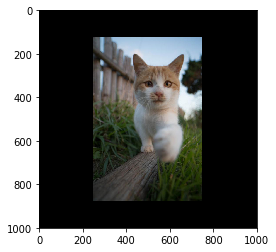

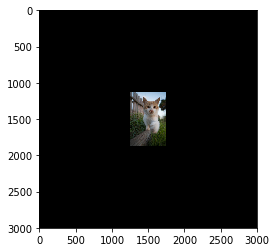

In [10]:
# 裁剪和填充
with tf.Session() as sess:    
    croped = tf.image.resize_image_with_crop_or_pad(img_data, 1000, 1000)
    padded = tf.image.resize_image_with_crop_or_pad(img_data, 3000, 3000)
    plt.imshow(croped.eval())
    plt.show()
    plt.imshow(padded.eval())
    plt.show()

In [6]:
# 截取中间50%
with tf.Session() as sess:   
    central_cropped = tf.image.central_crop(img_data, 0.5)
    plt.imshow(central_cropped.eval())
    plt.show()

In [9]:
# 翻转
with tf.Session() as sess: 
    # 上下翻转
    #flipped1 = tf.image.flip_up_down(img_data)
    # 左右翻转
    #flipped2 = tf.image.flip_left_right(img_data)
    
    #对角线翻转
    transposed = tf.image.transpose_image(img_data)
    plt.imshow(transposed.eval())
    plt.show()
    
    # 以一定概率上下翻转图片。
    #flipped = tf.image.random_flip_up_down(img_data)
    # 以一定概率左右翻转图片。
    #flipped = tf.image.random_flip_left_right(img_data)

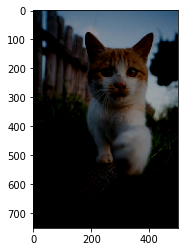

In [8]:
# 色彩调整
with tf.Session() as sess:     
    # 将图片的亮度-0.5。
    #adjusted = tf.image.adjust_brightness(img_data, -0.5)
    
    # 将图片的亮度-0.5
    #adjusted = tf.image.adjust_brightness(img_data, 0.5)
    
    # 在[-max_delta, max_delta)的范围随机调整图片的亮度。
    adjusted = tf.image.random_brightness(img_data, max_delta=0.5)
    
    # 将图片的对比度-5
    #adjusted = tf.image.adjust_contrast(img_data, -5)
    
    # 将图片的对比度+5
    #adjusted = tf.image.adjust_contrast(img_data, 5)
    
    # 在[lower, upper]的范围随机调整图的对比度。
    #adjusted = tf.image.random_contrast(img_data, lower, upper)

    plt.imshow(adjusted.eval())
    plt.show()

In [10]:
# 添加色相和饱和度
with tf.Session() as sess:         
    adjusted = tf.image.adjust_hue(img_data, 0.1)
    #adjusted = tf.image.adjust_hue(img_data, 0.3)
    #adjusted = tf.image.adjust_hue(img_data, 0.6)
    #adjusted = tf.image.adjust_hue(img_data, 0.9)
    
    # 在[-max_delta, max_delta]的范围随机调整图片的色相。max_delta的取值在[0, 0.5]之间。
    #adjusted = tf.image.random_hue(image, max_delta)
    
    # 将图片的饱和度-5。
    #adjusted = tf.image.adjust_saturation(img_data, -5)
    # 将图片的饱和度+5。
    #adjusted = tf.image.adjust_saturation(img_data, 5)
    # 在[lower, upper]的范围随机调整图的饱和度。
    #adjusted = tf.image.random_saturation(img_data, lower, upper)
    
    # 将代表一张图片的三维矩阵中的数字均值变为0，方差变为1。
    #adjusted = tf.image.per_image_whitening(img_data)
    
    plt.imshow(adjusted.eval())
    plt.show()

In [11]:
# 添加标注框并裁减
with tf.Session() as sess:         

    boxes = tf.constant([[[0.05, 0.05, 0.9, 0.7], [0.35, 0.47, 0.5, 0.56]]])

    begin, size, bbox_for_draw = tf.image.sample_distorted_bounding_box(
        tf.shape(img_data), bounding_boxes=boxes)


    batched = tf.expand_dims(tf.image.convert_image_dtype(img_data, tf.float32), 0) 
    image_with_box = tf.image.draw_bounding_boxes(batched, bbox_for_draw)
    
    distorted_image = tf.slice(img_data, begin, size)
    plt.imshow(distorted_image.eval())
    plt.show()

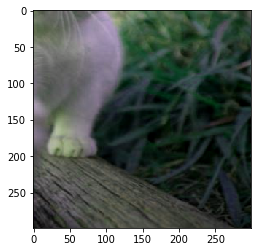

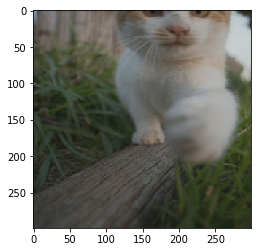

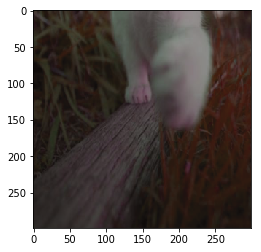

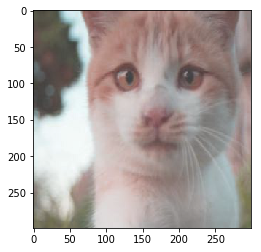

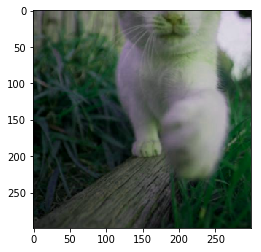

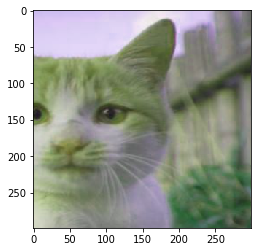

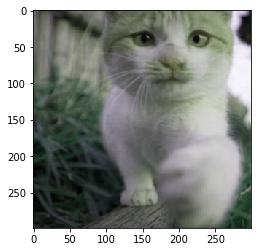

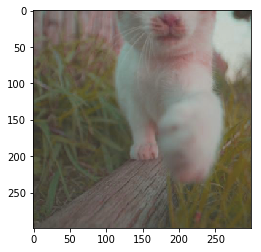

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
# 7.2.2 图像预处理完整样例
def distort_color(image, color_ordering=0):
    if color_ordering == 0:
        image = tf.image.random_brightness(image, max_delta=32./255.) # 随机亮度
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5) # 随机饱和度
        image = tf.image.random_hue(image, max_delta=0.2) # 随机色相
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5) # 随机对比度
    else:
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_brightness(image, max_delta=32./255.)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
        image = tf.image.random_hue(image, max_delta=0.2)

    return tf.clip_by_value(image, 0.0, 1.0)

def preprocess_for_train(image, height, width, bbox):
    # 查看是否存在标注框。
    if bbox is None:
        bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
    if image.dtype != tf.float32:
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        
    # 随机的截取图片中一个块。
    bbox_begin, bbox_size, _ = tf.image.sample_distorted_bounding_box(
        tf.shape(image), bounding_boxes=bbox)
    bbox_begin, bbox_size, _ = tf.image.sample_distorted_bounding_box(
        tf.shape(image), bounding_boxes=bbox)
    distorted_image = tf.slice(image, bbox_begin, bbox_size)

    # 将随机截取的图片调整为神经网络输入层的大小。
    distorted_image = tf.image.resize_images(distorted_image, [height, width], method=np.random.randint(4))
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = distort_color(distorted_image, np.random.randint(2))
    return distorted_image

# 读取图片
image_raw_data = tf.gfile.FastGFile("../../datasets/cat.jpeg", "rb").read()
with tf.Session() as sess:
    img_data = tf.image.decode_jpeg(image_raw_data)
    boxes = tf.constant([[[0.05, 0.05, 0.9, 0.7], [0.35, 0.47, 0.5, 0.56]]])
    for i in range(9):
        result = preprocess_for_train(img_data, 299, 299, boxes)
        plt.imshow(result.eval())
        plt.show()

In [3]:
# 7.3 多线程输入
import tensorflow as tf

# 创建先进先出队列，保存2个元素，整数型
q = tf.FIFOQueue(2, "int32")

# 初始化队列元素
init = q.enqueue_many(([0, 10],))

#队列出
x = q.dequeue()
y = x + 1

# 进队列
q_inc = q.enqueue([y])
with tf.Session() as sess:
    init.run()
    for _ in range(5):
        v, _ = sess.run([x, q_inc])
        print(v)

0
10
1
11
2


In [4]:
import numpy as np
import threading
import time
import tensorflow as tf

def MyLoop(coord, worker_id):
    # 使用tf.Coordinator类提供的协同工具以判断线程是否需要停止
    while not coord.should_stop():
        if np.random.rand() < 0.1:
            print("Stoping from id: %d\n" % worker_id,)
            coord.request_stop()
        else:
            print("Working on id: %d\n" % worker_id, )
        # 暂停一秒
        time.sleep(1)

# 声明一个tf.train.Coordinator类来协同多个线程
coord = tf.train.Coordinator()
# 声明创建5个线程 注意py3取消了xrange 用原来range代替效果相同
threads = [threading.Thread(target=MyLoop, args=(coord, i, )) for i in range(5)]
# 等待所有线程退出
for t in threads:t.start()
coord.join(threads)

Working on id: 0
Working on id: 1


Stoping from id: 2



In [5]:
# tf.QueueRunner启动多个线程来操作同一个队列
import tensorflow as tf

# 声明一个先进先出队列，最多元素为100个，类型为实数
queue = tf.FIFOQueue(100, "float")
# 定义队列的入队操作
enqueue_op = queue.enqueue([tf.random_normal([1])])

# 使用tf.train.QueueRunner来创建多个线程运行队列的入队操作
# 第一个参数为被操作的队列
# 启动5个线程，运行enqueue_op操作
qr = tf.train.QueueRunner(queue, [enqueue_op] * 5)

# 加入计算图
tf.train.add_queue_runner(qr)
out_tensor = queue.dequeue()

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    for _ in range(3): 
        print(sess.run(out_tensor)[0])
    
    coord.request_stop()
    coord.join(threads)

-0.8142683
-0.70171994
-0.6716043


In [4]:
# 7.3.2 输入文件队列
import tensorflow as tf
def _int64_feature(value):
    return tf.train.Feature(int64_list = tf.train.Int64List(value=[value]))

# 模拟数据情况，num_shards定义总共写入了多少文件
num_shards = 2
instances_per_shard = 2
for i in range(num_shards):
    filename = ('../../datasets/data.tfrecords-%.5d-of-%.5d' % (i, num_shards))
    writer = tf.python_io.TFRecordWriter(filename)
    
    # 将数据封装成Example结构写入TFRecord文件
    for j in range(instances_per_shard):
        example = tf.train.Example(features=tf.train.Features(feature={
            'i':_int64_feature(i),
            'j':_int64_feature(j)}))
        writer.write(example.SerializeToString())
    writer.close()

In [11]:
# 通过tf.train.match_filenames_once获取文件列表
files = tf.train.match_filenames_once("../../datasets/data.tfrecords-*")

# 通过tf.train.string_input_producer函数创建输入队列，即为文件列表
filename_queue = tf.train.string_input_producer(files, shuffle=False)

reader = tf.TFRecordReader()
_, serialized_example = reader.read(filename_queue)

features = tf.parse_single_example(
    serialized_example,
         features={
        'i': tf.FixedLenFeature([],tf.int64),
        'j': tf.FixedLenFeature([],tf.int64)
    })

with tf.Session() as sess:
    tf.local_variables_initializer().run()
    print(sess.run(files))
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    for i in range(6):
        print(sess.run([features['i'], features['j']]))
        
    coord.request_stop()
    coord.join(threads)

[b'..\\..\\datasets\\data.tfrecords-00000-of-00002'
 b'..\\..\\datasets\\data.tfrecords-00001-of-00002']
[0, 0]
[0, 1]
[1, 0]
[1, 1]
[0, 0]
[0, 1]


In [19]:
example, label = features['i'], features['j']
batch_size = 2
capacity = 1000 + 3 * batch_size
example_batch, label_batch = tf.train.batch([example, label], batch_size=batch_size, capacity=capacity)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    for i in range(3):
        cur_example_batch, cur_label_batch = sess.run([example_batch, label_batch])
        print(cur_example_batch, cur_label_batch)
        
    coord.request_stop()
    coord.join(threads)

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.FailedPreconditionError'>, Attempting to use uninitialized value matching_filenames
	 [[Node: matching_filenames/read = Identity[T=DT_STRING, _class=["loc:@matching_filenames"], _device="/job:localhost/replica:0/task:0/cpu:0"](matching_filenames)]]


OutOfRangeError: FIFOQueue '_146_batch_9/fifo_queue' is closed and has insufficient elements (requested 2, current size 0)
	 [[Node: batch_9 = QueueDequeueManyV2[component_types=[DT_INT64, DT_INT64], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](batch_9/fifo_queue, batch_9/n)]]

Caused by op 'batch_9', defined at:
  File "C:\Users\adward\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\adward\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\adward\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\adward\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\adward\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\adward\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\adward\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\adward\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\adward\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\adward\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\adward\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\adward\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\adward\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\adward\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\adward\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\adward\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\adward\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\adward\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\adward\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\adward\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-a1a90c8a6999>", line 4, in <module>
    example_batch, label_batch = tf.train.batch([example, label], batch_size=batch_size, capacity=capacity)
  File "C:\Users\adward\Anaconda3\lib\site-packages\tensorflow\python\training\input.py", line 919, in batch
    name=name)
  File "C:\Users\adward\Anaconda3\lib\site-packages\tensorflow\python\training\input.py", line 716, in _batch
    dequeued = queue.dequeue_many(batch_size, name=name)
  File "C:\Users\adward\Anaconda3\lib\site-packages\tensorflow\python\ops\data_flow_ops.py", line 457, in dequeue_many
    self._queue_ref, n=n, component_types=self._dtypes, name=name)
  File "C:\Users\adward\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_data_flow_ops.py", line 946, in _queue_dequeue_many_v2
    timeout_ms=timeout_ms, name=name)
  File "C:\Users\adward\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\adward\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\adward\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

OutOfRangeError (see above for traceback): FIFOQueue '_146_batch_9/fifo_queue' is closed and has insufficient elements (requested 2, current size 0)
	 [[Node: batch_9 = QueueDequeueManyV2[component_types=[DT_INT64, DT_INT64], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](batch_9/fifo_queue, batch_9/n)]]


In [20]:
# 7.3.4 输入数据处理框架
files = tf.train.match_filenames_once("../../datasets/data.tfrecords")
filename_queue = tf.train.string_input_producer(files, shuffle=False)

# 读取文件。

reader = tf.TFRecordReader()
_,serialized_example = reader.read(filename_queue)

# 解析读取的样例。
features = tf.parse_single_example(
    serialized_example,
    features={
        'image_raw':tf.FixedLenFeature([],tf.string),
        'pixels':tf.FixedLenFeature([],tf.int64),
        'label':tf.FixedLenFeature([],tf.int64)
    })

decoded_images = tf.decode_raw(features['image_raw'],tf.uint8)
retyped_images = tf.cast(decoded_images, tf.float32)
labels = tf.cast(features['label'],tf.int32)
#pixels = tf.cast(features['pixels'],tf.int32)
images = tf.reshape(retyped_images, [784])

min_after_dequeue = 10000
batch_size = 100
capacity = min_after_dequeue + 3 * batch_size

image_batch, label_batch = tf.train.shuffle_batch([images, labels], 
                                                    batch_size=batch_size, 
                                                    capacity=capacity, 
                                                    min_after_dequeue=min_after_dequeue)

def inference(input_tensor, weights1, biases1, weights2, biases2):
        layer1 = tf.nn.relu(tf.matmul(input_tensor, weights1) + biases1)
        return tf.matmul(layer1, weights2) + biases2

# 模型相关的参数
INPUT_NODE = 784
OUTPUT_NODE = 10
LAYER1_NODE = 500
REGULARAZTION_RATE = 0.0001   
TRAINING_STEPS = 5000        

weights1 = tf.Variable(tf.truncated_normal([INPUT_NODE, LAYER1_NODE], stddev=0.1))
biases1 = tf.Variable(tf.constant(0.1, shape=[LAYER1_NODE]))

weights2 = tf.Variable(tf.truncated_normal([LAYER1_NODE, OUTPUT_NODE], stddev=0.1))
biases2 = tf.Variable(tf.constant(0.1, shape=[OUTPUT_NODE]))

y = inference(image_batch, weights1, biases1, weights2, biases2)
    
# 计算交叉熵及其平均值
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y, labels=label_batch)
cross_entropy_mean = tf.reduce_mean(cross_entropy)
    
# 损失函数的计算
regularizer = tf.contrib.layers.l2_regularizer(REGULARAZTION_RATE)
regularaztion = regularizer(weights1) + regularizer(weights2)
loss = cross_entropy_mean + regularaztion

# 优化损失函数
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    
# 初始化回话并开始训练过程。
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    # 循环的训练神经网络。
    for i in range(TRAINING_STEPS):
        if i % 1000 == 0:
            print("After %d training step(s), loss is %g " % (i, sess.run(loss)))
                  
        sess.run(train_step) 
    coord.request_stop()
    coord.join(threads)

C:\Users\adward\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.FailedPreconditionError'>, Attempting to use uninitialized value matching_filenames
	 [[Node: matching_filenames/read = Identity[T=DT_STRING, _class=["loc:@matching_filenames"], _device="/job:localhost/replica:0/task:0/cpu:0"](matching_filenames)]]


OutOfRangeError: RandomShuffleQueue '_166_shuffle_batch/random_shuffle_queue' is closed and has insufficient elements (requested 100, current size 0)
	 [[Node: shuffle_batch = QueueDequeueManyV2[component_types=[DT_FLOAT, DT_INT32], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](shuffle_batch/random_shuffle_queue, shuffle_batch/n)]]

Caused by op 'shuffle_batch', defined at:
  File "C:\Users\adward\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\adward\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\adward\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\adward\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\adward\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\adward\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\adward\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\adward\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\adward\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\adward\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\adward\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\adward\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\adward\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\adward\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\adward\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\adward\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\adward\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\adward\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\adward\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\adward\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-34b52fc8ceb8>", line 32, in <module>
    min_after_dequeue=min_after_dequeue)
  File "C:\Users\adward\Anaconda3\lib\site-packages\tensorflow\python\training\input.py", line 1217, in shuffle_batch
    name=name)
  File "C:\Users\adward\Anaconda3\lib\site-packages\tensorflow\python\training\input.py", line 788, in _shuffle_batch
    dequeued = queue.dequeue_many(batch_size, name=name)
  File "C:\Users\adward\Anaconda3\lib\site-packages\tensorflow\python\ops\data_flow_ops.py", line 457, in dequeue_many
    self._queue_ref, n=n, component_types=self._dtypes, name=name)
  File "C:\Users\adward\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_data_flow_ops.py", line 946, in _queue_dequeue_many_v2
    timeout_ms=timeout_ms, name=name)
  File "C:\Users\adward\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\adward\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\adward\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

OutOfRangeError (see above for traceback): RandomShuffleQueue '_166_shuffle_batch/random_shuffle_queue' is closed and has insufficient elements (requested 100, current size 0)
	 [[Node: shuffle_batch = QueueDequeueManyV2[component_types=[DT_FLOAT, DT_INT32], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](shuffle_batch/random_shuffle_queue, shuffle_batch/n)]]
